# Imports

In [9]:
# 01_lorenz.ipynb  — project-quality Lorenz runs

import sys, os, time

sys.path.append(os.path.join("..", "src"))

import numpy as np
import jax.numpy as jnp
import pandas as pd

from systems import LorenzDefinition
from sindy_core import SINDyConfig
from run_model import (
    run_sindy_experiment,
    run_all_for_problem,
    load_experiment,
    print_equations_from_result,
    make_composite_figure,
)

# Run Lorenz

Saved: ../outputs/lorenz_baseline\Lorenz_fd_noise0.000.npz
[Lorenz baseline] finished in 71.08 s
Saved to: ../outputs/lorenz_baseline\Lorenz_fd_noise0.000.npz
Lorenz (fd, noise=0.000)

True system:
dx/dt = 10*(y - x)
dy/dt = x*(28 - z) - y
dz/dt = x*y - 2.66667*z

SINDy model:
dx/dt = -9.97878*x + 9.97865*y
dy/dt = 27.8079*x - 0.963476*y - 0.994559*x z
dz/dt = -2.65899*z + 0.997082*x y


c:\Users\brads\OneDrive - purdue.edu\Desktop\grad school\2025_3 fall\ME 69700 - Advanced Scientific Machine Learning\Project\code\sindy-project\notebooks\..\src\run_model.py:665: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\brads\AppData\Local\Temp\ipykernel_8372\713679485.py:87: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_base.show()


Saved: ../outputs/lorenz_derivatives\Lorenz\Lorenz_fd_noise0.000.npz
Saved: ../outputs/lorenz_derivatives\Lorenz\Lorenz_sg_noise0.000.npz
Saved: ../outputs/lorenz_derivatives\Lorenz\Lorenz_tv_noise0.000.npz


c:\Users\brads\OneDrive - purdue.edu\Desktop\grad school\2025_3 fall\ME 69700 - Advanced Scientific Machine Learning\Project\code\sindy-project\notebooks\..\src\run_model.py:665: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\brads\AppData\Local\Temp\ipykernel_8372\713679485.py:191: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Saved: ../outputs/lorenz_noise\Lorenz\Lorenz_fd_noise0.000.npz
Saved: ../outputs/lorenz_noise\Lorenz\Lorenz_fd_noise0.010.npz


c:\Users\brads\OneDrive - purdue.edu\Desktop\grad school\2025_3 fall\ME 69700 - Advanced Scientific Machine Learning\Project\code\sindy-project\notebooks\..\src\run_model.py:665: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\brads\AppData\Local\Temp\ipykernel_8372\713679485.py:224: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


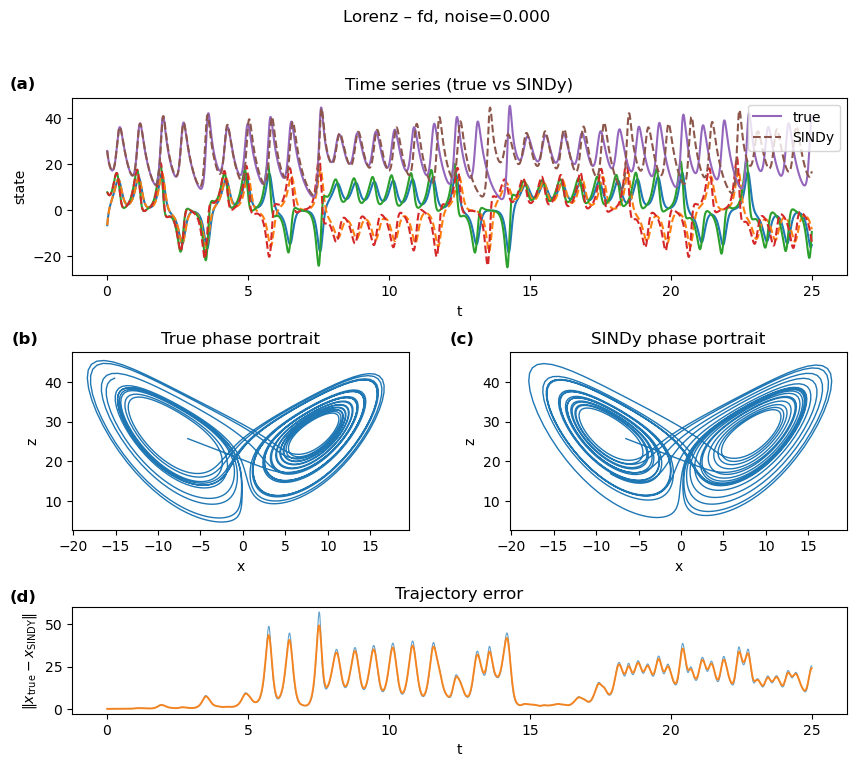

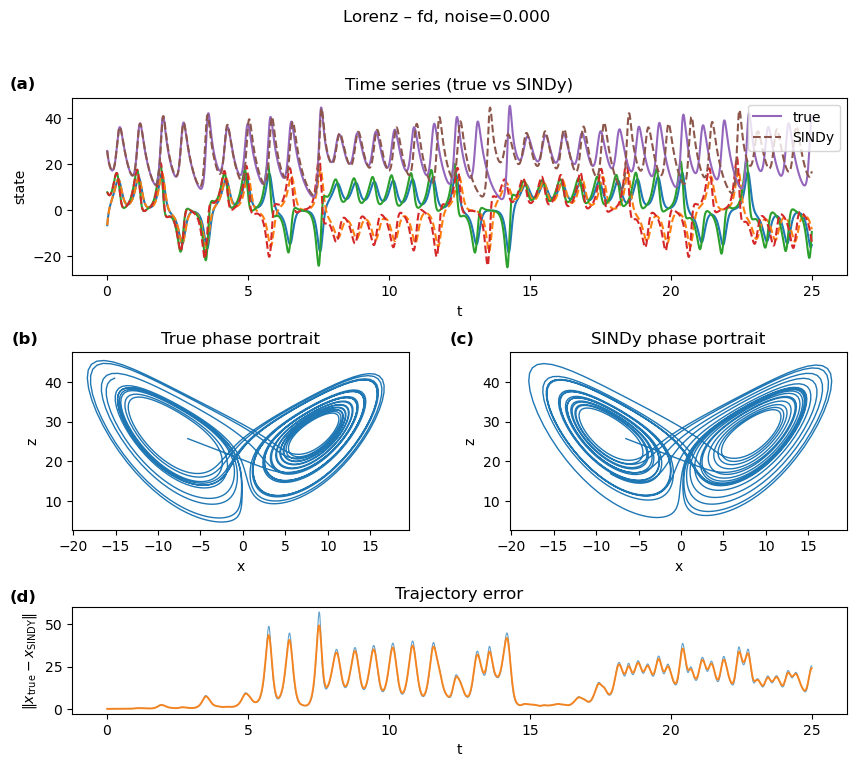

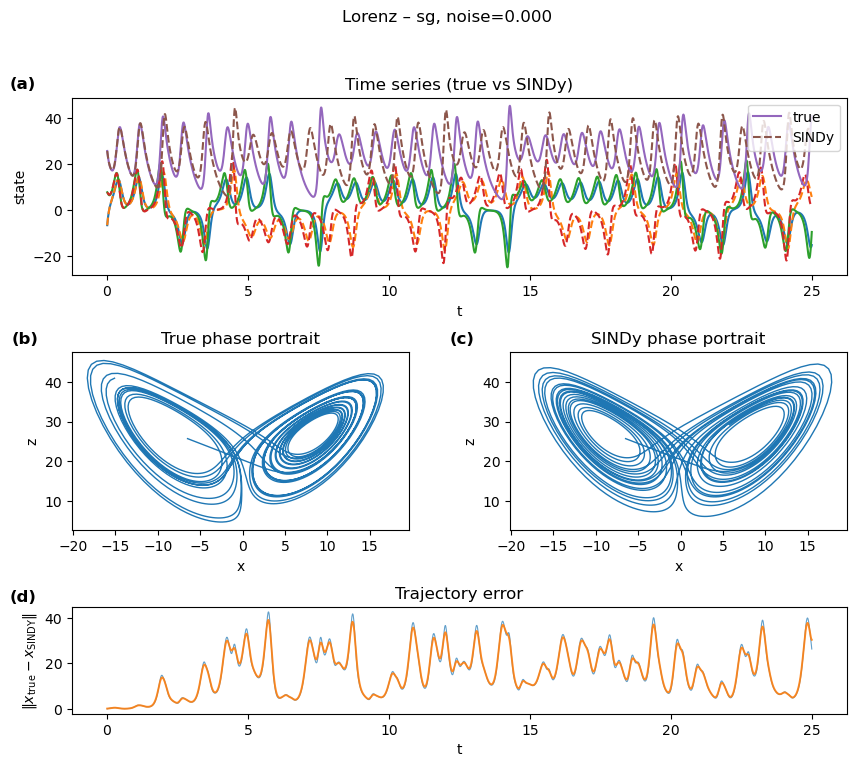

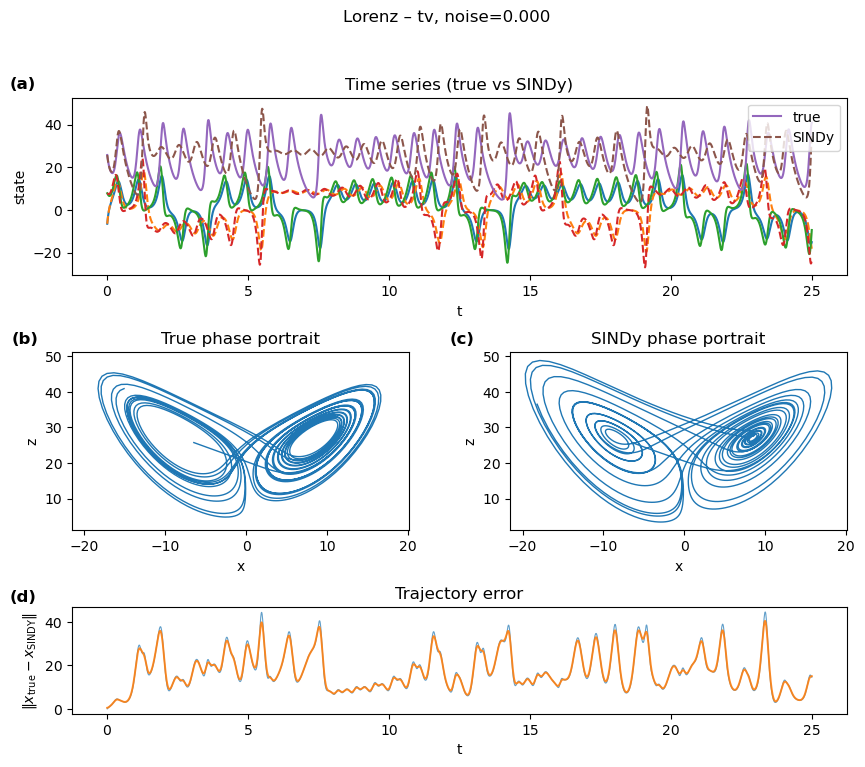

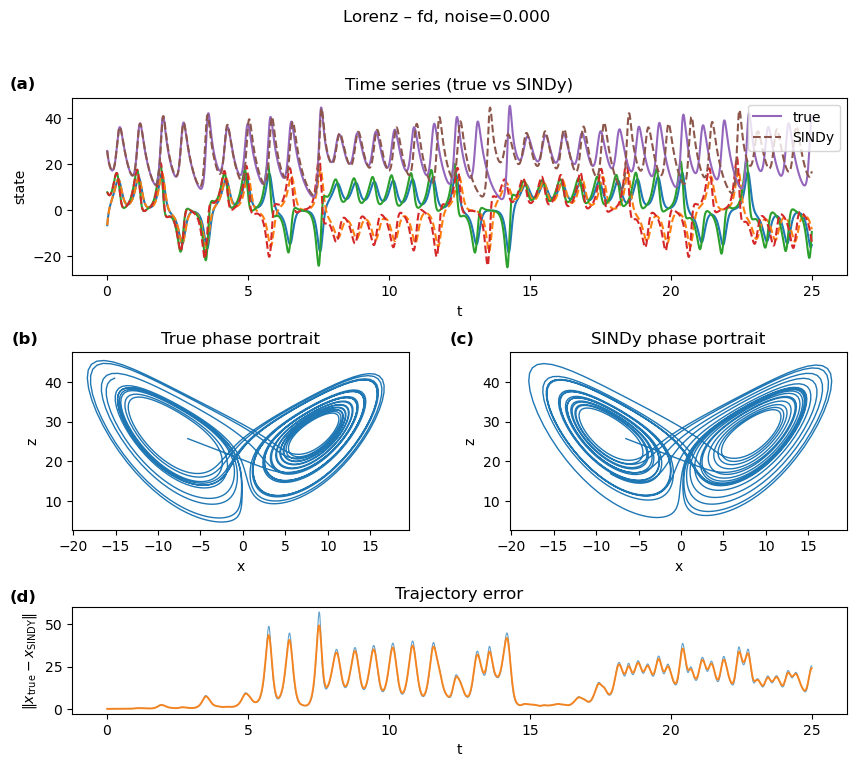

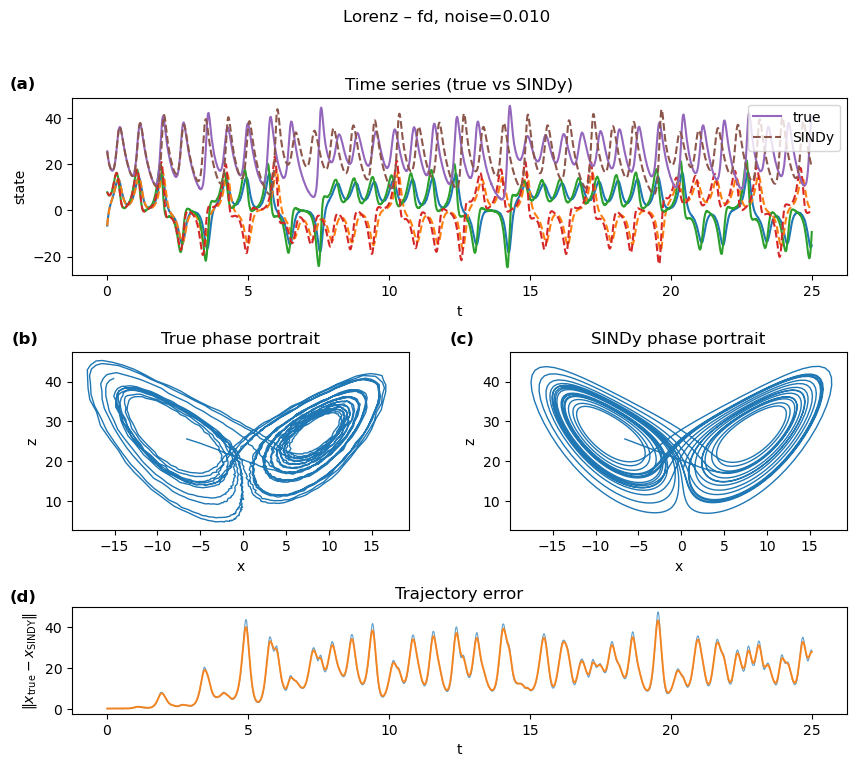

In [ ]:


# -------------------------------------------------------
# 0. Common Lorenz setup + SINDy config (project defaults)
# -------------------------------------------------------
lorenz_params = dict(
    sigma=10.0,
    rho=28.0,
    beta=8.0 / 3.0,
)

lorenz_problem = LorenzDefinition(
    parameters=lorenz_params,
    x0_vector=jnp.array([-8.0, 8.0, 27.0]),
    t0=0.0,
    tf=25.0,
    dt=0.01,
)

cfg_lorenz = SINDyConfig(
    poly_degree=2,  # standard Lorenz setting for this project
    include_bias=True,
    threshold=0.1,
    n_iter=10,
    post_tol=1e-2,
    var_names=("x", "y", "z"),
    mode="polynomial",
    stlsq_mode="pruned",  # Brunton-style column pruning
    normalize=False,  # project default
)

FIG_DIR = "../figs"
OUT_BASELINE = "../outputs/lorenz_baseline"
OUT_DERIV = "../outputs/lorenz_derivatives"
OUT_NOISE = "../outputs/lorenz_noise"

os.makedirs(FIG_DIR, exist_ok=True)

# =======================================================
# 1. Baseline run: FD derivatives, no noise
# =======================================================
t0 = time.perf_counter()
baseline_path = run_sindy_experiment(
    problem=lorenz_problem,
    deriv_key="fd",
    noise_level=0.0,
    sindy_config=cfg_lorenz,
    outdir=OUT_BASELINE,
    drop_transient=0.0,
)
elapsed = time.perf_counter() - t0
print(f"[Lorenz baseline] finished in {elapsed:.2f} s")
print("Saved to:", baseline_path)

baseline_result = load_experiment(baseline_path)
print_equations_from_result(baseline_result)

fig_base, axes_base = make_composite_figure(
    baseline_result,
    phase_i=0,
    phase_j=2,  # x–z projection
    labels=["x", "y", "z"],
)
fig_base.savefig(
    os.path.join(FIG_DIR, "lorenz_fd_clean_composite.png"),
    dpi=300,
    bbox_inches="tight",
)
fig_base.show()


# =======================================================
# 2. Coefficient comparison table vs true Lorenz system
# =======================================================
def build_lorenz_coeff_table(result, params):
    """
    Build a table comparing SINDy coefficients to the analytic
    Lorenz coefficients for poly degree=2, include_bias=True.
    """
    feature_names = [str(s) for s in result["feature_names"]]
    Xi = np.asarray(result["Xi"])  # shape (n_features, 3)

    sigma = float(params["sigma"])
    rho = float(params["rho"])
    beta = float(params["beta"])

    n_feat = len(feature_names)
    true_coeffs = np.zeros((n_feat, 3))

    for i, name in enumerate(feature_names):
        # dx/dt = -sigma x + sigma y
        if name == "x":
            true_coeffs[i, 0] = -sigma
        elif name == "y":
            true_coeffs[i, 0] = sigma

        # dy/dt = rho x - x z - y
        if name == "x":
            true_coeffs[i, 1] = rho
        elif name == "y":
            true_coeffs[i, 1] = -1.0
        elif name == "x z":
            true_coeffs[i, 1] = -1.0

        # dz/dt = x y - beta z
        if name == "x y":
            true_coeffs[i, 2] = 1.0
        elif name == "z":
            true_coeffs[i, 2] = -beta

    diff = Xi - true_coeffs

    df = pd.DataFrame(
        {
            "feature": feature_names,
            "dx_true": true_coeffs[:, 0],
            "dx_SINDy": Xi[:, 0],
            "dx_diff": diff[:, 0],
            "dy_true": true_coeffs[:, 1],
            "dy_SINDy": Xi[:, 1],
            "dy_diff": diff[:, 1],
            "dz_true": true_coeffs[:, 2],
            "dz_SINDy": Xi[:, 2],
            "dz_diff": diff[:, 2],
        }
    )

    return df


lorenz_coeff_table = build_lorenz_coeff_table(baseline_result, lorenz_params)
lorenz_coeff_table.round(4)

# (Optional) save as CSV or markdown for the report
lorenz_coeff_table.round(4).to_csv(
    os.path.join(FIG_DIR, "lorenz_fd_clean_coeffs.csv"),
    index=False,
)
# lorenz_coeff_table.round(4).to_markdown()

# =======================================================
# 3. Derivative comparison: FD vs SG vs TV (no noise)
# =======================================================
run_all_for_problem(
    problem=lorenz_problem,
    sindy_config=cfg_lorenz,
    out_root=OUT_DERIV,
    drop_transient=0.0,
    deriv_keys=("fd", "sg", "tv"),
    noise_levels=(0.0,),
)

deriv_keys = ("fd", "sg", "tv")
for deriv in deriv_keys:
    path = os.path.join(
        OUT_DERIV,
        lorenz_problem.name,
        f"{lorenz_problem.name}_{deriv}_noise0.000.npz",
    )
    res = load_experiment(path)
    fig, axes = make_composite_figure(
        res,
        phase_i=0,
        phase_j=2,
        labels=["x", "y", "z"],
    )
    fname = f"lorenz_{deriv}_clean_composite.png"
    fig.savefig(
        os.path.join(FIG_DIR, fname),
        dpi=300,
        bbox_inches="tight",
    )
    fig.show()

# =======================================================
# 4. Noise comparison: FD, noise = 0 vs 1%
# =======================================================
run_all_for_problem(
    problem=lorenz_problem,
    sindy_config=cfg_lorenz,
    out_root=OUT_NOISE,
    drop_transient=0.0,
    deriv_keys=("fd",),
    noise_levels=(0.0, 0.01),
)

for noise in (0.0, 0.01):
    path = os.path.join(
        OUT_NOISE,
        lorenz_problem.name,
        f"{lorenz_problem.name}_fd_noise{noise:0.3f}.npz",
    )
    res = load_experiment(path)
    fig, axes = make_composite_figure(
        res,
        phase_i=0,
        phase_j=2,
        labels=["x", "y", "z"],
    )
    fname = f"lorenz_fd_noise{noise:0.3f}_composite.png"
    fig.savefig(
        os.path.join(FIG_DIR, fname),
        dpi=300,
        bbox_inches="tight",
    )
    fig.show()

# Compare discovered parameters for each derivative method

In [3]:
import numpy as np

files = {
    "FD": "../outputs/lorenz_derivatives/lorenz/Lorenz_fd_noise0.000.npz",
    "SG": "../outputs/lorenz_derivatives/lorenz/Lorenz_sg_noise0.000.npz",
    "TV": "../outputs/lorenz_derivatives/lorenz/Lorenz_tv_noise0.000.npz",
}

TRUE = {"sigma": 10.0, "rho": 28.0, "beta": 8 / 3}


def extract_params(path):
    d = np.load(path, allow_pickle=True)
    Xi = d["Xi"]  # (n_features, 3)
    names = [s.replace(" ", "") for s in d["feature_names"].tolist()]
    idx = {n: i for i, n in enumerate(names)}

    ix, iy, iz = idx["x"], idx["y"], idx["z"]

    sigma = 0.5 * (-Xi[ix, 0] + Xi[iy, 0])
    rho = Xi[ix, 1]
    beta = -Xi[iz, 2]

    return float(sigma), float(rho), float(beta)


rows = {}
for k, f in files.items():
    sigma, rho, beta = extract_params(f)
    rows[k] = {
        "sigma": sigma,
        "dsigma": abs(sigma - TRUE["sigma"]),
        "rho": rho,
        "drho": abs(rho - TRUE["rho"]),
        "beta": beta,
        "dbeta": abs(beta - TRUE["beta"]),
    }

rows

{'FD': {'sigma': 9.978718757629395,
  'dsigma': 0.02128124237060547,
  'rho': 27.807931900024414,
  'drho': 0.19206809997558594,
  'beta': 2.6589856147766113,
  'dbeta': 0.0076810518900551905},
 'SG': {'sigma': 9.92486572265625,
  'dsigma': 0.07513427734375,
  'rho': 26.815284729003906,
  'drho': 1.1847152709960938,
  'beta': 2.6303977966308594,
  'dbeta': 0.036268870035807144},
 'TV': {'sigma': 9.841218948364258,
  'dsigma': 0.1587810516357422,
  'rho': 25.12497329711914,
  'drho': 2.8750267028808594,
  'beta': 2.239644765853882,
  'dbeta': 0.4270219008127847}}